# Classificando nomes com uma *Character-Level RNN*

https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb

---



### Problema: Dado um nome próprio de entrada, classificar esse nome de acordo com a nacionalidade a que ele pertence.

python predict.py **Hinton**

(-0.47) Scottish

(-1.52) English

(-3.57) Irish


-

python predict.py **Schmidhuber**

(-0.19) German

(-2.48) Czech

(-2.68) Dutch


---
### Import de bibliotecas

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
  
import unicodedata
import torch
import string
import torch.nn as nn
from torch.autograd import Variable
import sys, random, os
import matplotlib.pyplot as plt

%matplotlib inline


---

### Importando dataset

In [2]:
# comente as duas linhas seguintes caso rode mais de uma vez
!wget https://download.pytorch.org/tutorial/data.zip #
!unzip data.zip #
############################################################

root_path = 'data/names/'
all_filenames = []
for file_name in os.listdir(root_path):
  all_filenames.append(os.path.join(root_path,file_name))

--2018-08-16 14:55:10--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.147.231, 54.230.147.109, 54.230.147.13, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.147.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  1.65MB/s    in 1.7s    

2018-08-16 14:55:12 (1.65 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names

In [3]:
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    #return lines
    return [unicodedata.normalize('NFKD', line).encode('ascii', 'ignore') for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


In [4]:
category_lines['Italian'][:5]

[b'Abandonato', b'Abatangelo', b'Abatantuono', b'Abate', b'Abategiovanni']


---
### Convertendo caracteres para tensores
Nesse caso, cada caracter será convertido para uma representação *one-hot*


In [0]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for li, letter in enumerate(line.decode('utf-8')):
        letter_index = all_letters.find(letter)
        tensor[li][letter_index] = 1
    return tensor

In [6]:
print(letter_to_tensor('a'))



Columns 0 to 12 
    1     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]





---


### Funções auxiliares para estruturar as amostras de treino e teste

In [0]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i]

In [0]:
from sklearn.model_selection import train_test_split as split

X_train, X_test = {}, {}
for category in all_categories:
  train, test = split(category_lines[category], test_size=0.1)
  
  X_train[category] = train
  X_test[category] = test



---

### Construindo modelo RNN

* Implemente um modelo para classificação de nomes próprios (série de caracteres) usando apenas camadas *RNNCell*, *Linear* e ativação *LogSoftmax*
* Cada entrada (caracter) possui dimensão (57): alfabeto maiúsculo e minúsculo
* *Hidden size* possui dimensão (256): hiperparâmetro 
* Saída possui dimensão (18): vetor de probabilidade de classes
* Batch size = 1 de acordo com a implementação do loop de treinamento

**Links úteis**

RNNCell: https://pytorch.org/docs/stable/nn.html#torch.nn.RNNCell

Linear: https://pytorch.org/docs/stable/nn.html#torch.nn.Linear

Non-linear activations: https://pytorch.org/docs/stable/nn.html#non-linear-activations-other



In [14]:
class CustomNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.rnn    = nn.RNNCell(self.input_size, self.hidden_size, nonlinearity='tanh')
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input):
      
        # Set initial hidden state 
        #self.hidden = Variable(torch.zeros(1, self.hidden_size).double())
        self.hidden = Variable(torch.zeros(1, self.hidden_size).double()).cuda() #GPU
       
        for i, input_t in enumerate(input):
          self.hidden = self.rnn(input_t, self.hidden)
        
        output = self.linear(self.hidden)
        output = self.softmax(output) 
        return output

n_hidden = 256
model = CustomNetwork(n_letters, n_hidden, n_categories)
model.double().cuda() #GPU

CustomNetwork(
  (rnn): RNNCell(57, 256)
  (linear): Linear(in_features=256, out_features=18)
  (softmax): LogSoftmax()
)



---

### Instanciando *Loss* e Otimizador

In [0]:
criterion = nn.NLLLoss().cuda() #GPU
learning_rate  = 0.0002 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



---

### Treinando / Testando modelo

In [16]:
num_epochs = 20
num_steps  = 2000
print_every = 2000

current_loss = 0
current_acc = 0
all_losses, all_val_losses, all_acc, all_val_acc = [], [], [], []
for epoch in range(num_epochs):  

  for step in range(num_steps):
    
    # Set to Train Mode
    model.train()
    
    category = random.choice(all_categories)
    line = random.choice(X_train[category])
  
    #category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    #line_tensor     = Variable(line_to_tensor(line))
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)])).cuda() #GPU
    line_tensor     = Variable(line_to_tensor(line)).double().cuda() #GPU

    # Forward pass
    output = model(line_tensor)
    loss = criterion(output, category_tensor)
    current_loss += loss
    current_acc  += 1 if category_from_output(output) == category else 0
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (step+1) % print_every == 0:
      
      #Set to evaluation mode
      model.eval()
      n_test_steps = 100
      
      test_loss, acc = 0, 0
      for tstep in range(n_test_steps):
      
        category = random.choice(all_categories)
        line = random.choice(X_test[category])

        #category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        #line_tensor     = Variable(line_to_tensor(line))
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)])).cuda() #GPU
        line_tensor     = Variable(line_to_tensor(line)).double().cuda() #GPU

        output = model(line_tensor)
        loss = criterion(output, category_tensor)
        test_loss += loss
        acc += 1 if category_from_output(output) == category else 0
      
      
      current_loss = current_loss.data[0]/float(print_every)
      current_acc  = current_acc/float(print_every)
      test_loss    = test_loss.data[0]/float(n_test_steps)
      acc          = acc/float(n_test_steps)
      
      print('\rEpoch: {0} Train Loss: {2} Train Acc: {3}% Val Loss: {4}  Val Acc: {5}%'.format(epoch+1, step, current_loss, current_acc*100, test_loss, acc*100))

      all_losses.append(current_loss)
      all_acc.append(current_acc)
      all_val_losses.append(test_loss)
      all_val_acc.append(acc)

      current_loss = 0
      current_acc  = 0
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 Train Loss: 2.5932482598422024 Train Acc: 18.95% Val Loss: 2.291993728423328  Val Acc: 31.0%
Epoch: 2 Train Loss: 2.237842909781253 Train Acc: 30.7% Val Loss: 2.190452787442263  Val Acc: 28.000000000000004%
Epoch: 3 Train Loss: 1.9632929219768236 Train Acc: 38.6% Val Loss: 1.9738149352787233  Val Acc: 34.0%
Epoch: 4 Train Loss: 1.817804701059128 Train Acc: 42.85% Val Loss: 1.7742464042919166  Val Acc: 47.0%
Epoch: 5 Train Loss: 1.7450741762615367 Train Acc: 44.45% Val Loss: 1.711818576149417  Val Acc: 41.0%
Epoch: 6 Train Loss: 1.6299343343097865 Train Acc: 47.5% Val Loss: 1.7745191055009493  Val Acc: 39.0%
Epoch: 7 Train Loss: 1.5851291293788574 Train Acc: 48.9% Val Loss: 1.9444058991028284  Val Acc: 35.0%
Epoch: 8 Train Loss: 1.5357069794548366 Train Acc: 51.7% Val Loss: 1.6013881732762676  Val Acc: 43.0%
Epoch: 9 Train Loss: 1.4255031189706486 Train Acc: 54.7% Val Loss: 1.6130452637232893  Val Acc: 48.0%
Epoch: 10 Train Loss: 1.4201445274339723 Train Acc: 54.1% Val Loss: 2.



---


### Análise e plots

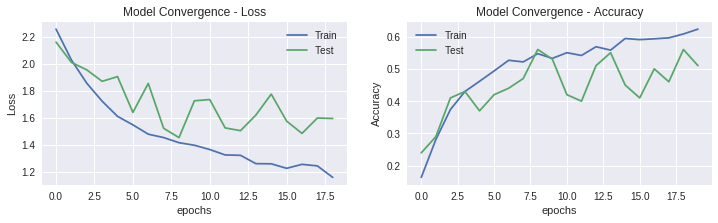

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))


ax1.plot(all_losses[1:], label='Train')
ax1.plot(all_val_losses[1:], label='Test')
ax1.set_title('Model Convergence - Loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(all_acc, label='Train')
ax2.plot(all_val_acc, label='Test')
ax2.set_title('Model Convergence - Accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()



---

### Fazendo predições com entradas de usuário

In [13]:
def predict_input(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    
    tensor = torch.zeros(len(input_line), n_letters)
    for li, letter in enumerate(input_line):
        letter_index = all_letters.find(letter)
        tensor[li][letter_index] = 1
        
    output = model(Variable(tensor).double().cuda())

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict_input('Mbappe')
predict_input('Guillermo')
predict_input('Kyle')


> Mbappe
(-1.39) Spanish
(-1.63) French
(-1.78) Portuguese

> Guillermo
(-0.09) Portuguese
(-3.00) Spanish
(-3.65) Italian

> Kyle
(-0.27) Scottish
(-1.79) English
(-3.63) Irish


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
